DQN
-------------

这个项目是pytorch文档里的[REINFORCEMENT LEARNING (DQN) TUTORIAL](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)。


算法介绍：

首先如果采用online Q-Learning的方式，通过$\epsilon$-greedy策略采样a，然后观察$(s,a,r,s')$。再通过$\Delta \mathbf{w}=\alpha\left(r+\gamma \max _{a^{\prime}} \hat{q}\left(s^{\prime}, a^{\prime}, \mathbf{w}\right)-\hat{q}(s, a, \mathbf{w})\right) \nabla_{\mathbf{w}} \hat{q}(s, a, \mathbf{w})$更新参数，这样会导致序列state有很强的相关性，并且target value 会一直变化。

​		所以提出了DQN算法，采用了**experience replay** 和 **target network** 来解决上述问题，DQN的算法流程如下所示：

<img src="https://cdn.mathpix.com/snip/images/DJAT5cf-ZOB65SXSwyrCi0RDSiiaVtw7B_j6deRlqsU.original.fullsize.png" style="zoom: 67%;" />



In [26]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v0').unwrapped # unwrapped是打开限制的意思，据说不做这个动作会有很多限制

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Replay Memory
-------------

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment. It essentially maps (state, action) pairs
   to their (next_state, reward) result, with the state being the
   screen difference image as described later on.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.

In [27]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0#标记下一个transition存入的位置

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:#如果memory的大小还达不到capacity，则append一个None
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

DQN算法
-------------

DQN的误差计算

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

优化时采用Huber loss：

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

=============

Q-network

=============

我们的模型将是一个卷积神经网络，该卷积神经网络将吸收当前屏幕补丁和先前屏幕补丁之间的差异。
它有两个输出，分别代表𝑄（𝑠，left）和𝑄（𝑠，right）（其中𝑠是网络的输入）。
实际上，网络正在尝试预测在给定当前输入的情况下采取每个操作的预期收益。

In [28]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

==================

Input extraction

==================

以下代码是用于从环境中提取和处理渲染图像的实用程序。get_screen()的shape为[1, 3, 40, 90]

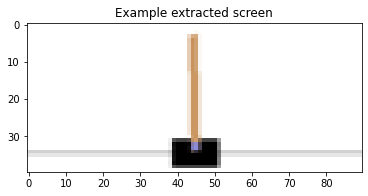

In [43]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # 车子的中心

def get_screen():
    # 返回 gym 需要的400x600x3 图片, 但有时会更大，如800x1200x3. 将其转换为torch (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # 车子在下半部分，因此请剥去屏幕的顶部和底部。
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # 去掉边缘，这样我们就可以得到一个以车为中心的正方形图像。
    screen = screen[:, :, slice_range]
    # 转化为 float, 重新裁剪, 转化为 torch 张量(这并不需要拷贝)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # 重新裁剪,加入批维度 (BCHW)
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

Training
--------

==============================

Hyperparameters and utilities

==============================

该单元实例化我们的模型及其优化器，并定义一些实用程序：

-  ``select_action`` - 将根据epsilon贪婪策略选择一个操作。简而言之，我们有时会使用模型来选择动作，有时我们只会统一采样。选择随机动作的可能性将从EPS_START开始，并朝EPS_END呈指数衰减。 EPS_DECAY控制衰减率。

-  ``plot_durations`` - 一个帮助绘制episodes持续时间以及最近100个episodes的平均值（官方评估中使用的度量）的助手。该episodes将在包含主要训练循环的单元格下方，并且将在每个episodes之后更新。

In [45]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# 获取屏幕尺寸，以便我们可以根据形状正确初始化图层
# shape为3x40x90

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# action的数量
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        #贪心
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        #随机
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

==============
Training loop

==============

最后，是训练模型的代码。


Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By defition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network has its weights kept frozen most of
the time, but is updated with the policy network's weights every so often.
This is usually a set number of steps but we shall use episodes for
simplicity.




In [41]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    #计算Q(s_t,a)，模型计算出Q(s_t)，然后我们选择出每个批次里a_t的Q值。
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 计算 V(s_{t+1})
    # non_final_next_states的预期动作值是根据“较旧的” target_net计算的；用max（1）[0]选择他们的最佳奖励。
    # 这是根据掩码合并的，这样我们可以得到预期的状态值，而在状态为最终状态的情况下为0。
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # 计算预期的Q值
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

在下面，您可以找到主要的训练循环。首先，我们重置环境并初始化状态Tensor。然后，我们对一个动作进行采样，执行它，观察下一个屏幕和奖励（总是1），并一次优化我们的模型。当情节结束时（我们的模型失败），我们重新开始循环。

In [44]:
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>

总结：
* expected_state_action_values即$(r + \gamma \max_a Q(s', a))$是用“旧的”target network计算，而state_action_values$Q(s,a)$用policy的target network计算。
* 

问题：
* memory的大小设置，memory如果不能及时更新会不会targt。
* optimize_model()是在每一个episode执行一次还是在每一个episode的每一步执行一次。